## Chain

세 변수 ${X, Y, Z}$는 $Z$가 $X$에서 $Y$로의 인과 흐름을 매개할 때 **체인(chain)** 을 형성한다(그림 19 참조). 연구자가 $Y$를 $X$의 함수로 모델링할 경우, $Z$는 **매개 변수(mediator variable)** 라고 한다.

확률분포함수 $P$가 주어졌다는 가정 하에서 베이지안 네트워크 분해를 적용하면 다음과 같다.

$$
P[X,Y,Z]=P[X]P[Z|X]P[Y|Z]
$$  

이 식은 $X$와 $Y$가 인과 경로를 통해 연관됨을 의미한다.

$$
P[X,Y]=\sum_{Z}P[X]P[Z|X]P[Y|Z]\neq P[X]P[Y]
$$  

그림 19에는 Backdoor Path가 존재하지 않는다. 이는 $X$와 $Y$가 $Z$에 의해 매개된 인과 경로를 통해서만 연관된 예시이다. 분기의 경우와 유사하게, $Z$에 대한 조건부화는 **do-calculus(개입)** 을 시뮬레이션한 것과 같아 $X$와 $Y$의 조건부 독립을 초래한다.

$$
P[X,Y|Z]={\frac{P[X,Y,Z]}{P[Z]}}={\frac{P[X]P[Z|X]P[Y|Z]}{P[Z]}}={\frac{P[X,Z]}{P[Z]}}P[Y|Z]=P[X|Z]P[Y|Z]
$$  

매개 변수에 대해 조건부화하는 문제는 연구자가 추정하고자 하는 인과 연관을 방해할 수 있다(과도한 통제, 6.4.2.2절 참조). 이로 인해 **false negative**가 발생할 수 있다. 더 나아가 매개 변수에 대한 조건부화는 **false positive**를 초래할 수도 있다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

매개 변수(mediator)에 대해 조건부화할 때의 문제는 연구자가 추정하고자 하는 인과 관계를 방해할 수 있다는 점이다(과도한 통제의 사례, 6.4.2.2절 참조). 이로 인해 **false negative**가 발생할 수 있다. 더 복잡하게는 매개 변수에 대한 조건부화가 **false positive**를 초래할 수도 있다. 이를 검증하기 위해 다음과 같은 수치 실험을 수행할 수 있다. 먼저, 구조 방정식 모델에 따라 5,000개의 관측값을 생성한다.

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

np.random.seed(42) # set random seed

In [3]:
x = np.random.normal(size = 5000) # false cause
w = np.random.normal(size = x.shape[0]) # confounder
z = x + w + np.random.normal(size = x.shape[0]) # mediator
y = z + w + np.random.normal(size = x.shape[0]) # effect

다음 선형 방정식을 적합시킨다

$$
\begin{array}{r l}&{X_{t}:=\epsilon_{t}}\\ &{W_{t}:=\eta_{t}}\\ &{Z_{t}:=X_{t}+W_{t}+\zeta_{t}}\\ &{Y_{t}:=Z_{t}+W_{t}+\zeta_{t}}\end{array}
$$  

여기서 ${\xi_{t}, \epsilon_{t}, \zeta_{t}, \eta_{t}}$는 독립적인 표준 정규분포를 따르는 네 개의 랜덤 변수이다. 아래의 그림은 관련된 인과 그래프를 보여준다.

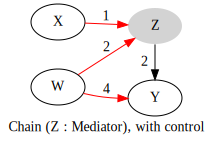

In [4]:
import graphviz as gr

chain = gr.Digraph(
    'G',
    node_attr = {'shape': 'ellipse'}, 
    graph_attr = {
        'rankdir': 'LR',
        'label': 'Chain (Z : Mediator), with control'
    }
)

chain.edge('X', 'Z', label = '1', color = 'red')
chain.edge('W', 'Z', label = '2', color = 'red')
chain.edge('W', 'Y', label = '4', color = 'red')
chain.edge('Z', 'Y', label = '2')

chain.node(
    'Z', style = 'filled', 
    fillcolor = 'lightgray', 
    shape = 'ellipse', 
    penwidth = '0'
)

with chain.subgraph() as s:
    s.attr(rank = 'same') 
    s.node('Z')
    s.node('Y')

chain

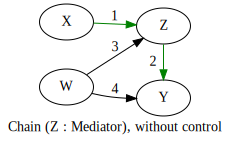

In [5]:
chain = gr.Digraph(
    'G',
    node_attr = {'shape': 'ellipse'}, 
    graph_attr = {
        'rankdir': 'LR',
        'label': 'Chain (Z : Mediator), without control'
    }
)

chain.edge('X', 'Z', label = '1', color = 'green')
chain.edge('W', 'Z', label = '3')
chain.edge('W', 'Y', label = '4')
chain.edge('Z', 'Y', label = '2', color = 'green')

with chain.subgraph() as s:
    s.attr(rank = 'same') 
    s.node('Z')
    s.node('Y')

chain

이후, 생성된 5,000개의 관측값에 다음 선형 방정식을 적합시킨다.

$$
Y_{t}=\alpha+\beta X_{t}+\gamma Z_{t}+\varepsilon_{t}.
$$  

In [6]:
# Incorrect estimate of X -> Y
X = np.column_stack((x, z))

In [7]:
ols0 = sm.OLS(
    y, sm.add_constant(X)
).fit()

In [8]:
print(ols0.summary(xname = ['const','X','Z'], yname = 'Y')) # false positive

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     9296.
Date:                Thu, 31 Oct 2024   Prob (F-statistic):               0.00
Time:                        00:53:31   Log-Likelihood:                -8085.1
No. Observations:                5000   AIC:                         1.618e+04
Df Residuals:                    4997   BIC:                         1.620e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.017      0.365      0.7

그림 21은 최소제곱 추정 결과를 보여준다. 비록 $X$가 $Z$를 통해 $Y$에 영향을 미치긴 하지만, 이 결과는 여전히 **false positive**이다. 보고된 연관이 인과 경로 $X \rightarrow Z \rightarrow Y$를 통해 흐르지 않았기 때문이다. 이는 $Z$가 $X$와 $W$ 사이의 충돌부로 작동하며, $Z$를 통제하면서 Backdoor Path $X \rightarrow Z \leftarrow W \rightarrow Y$가 열리기 때문이다. 이로 인해 $\hat{\boldsymbol{\beta}} \ll 0$가 되며, 모든 효과가 양수임에도 이러한 결과가 나타난다. 이 현상은 **매개 오류(mediation fallacy)** 로, 매개 변수와 결과가 혼란될 때 매개 변수를 조건부화하는 경우 발생한다(Pearl and MacKenzie, 2018, p. 315). 이 실험은 또한 **심슨의 역설(Simpson’s Paradox)** 을 보여주는데, 이는 여러 그룹의 데이터에서 관찰된 연관이 그룹을 결합하면 사라지거나 반전되는 현상이다(Pearl et al., 2016, pp. 1–6).

do-calculus 규칙에 따르면, 이 인과 그래프에서 $X$가 $Y$에 미치는 영향은 통제 없이도 추정할 수 있다. 그 이유는, $W$를 통한 비인과 경로가 이미 $Z$에 의해 차단되었기 때문이다. $\hat{\boldsymbol{\beta}}$의 편향을 제거하기 위해 $W$를 통제할 필요는 없지만, 통제하면 추정의 정확도를 향상시킬 수 있다. 다음과 같은 모델 명세가 $\beta$에 대한 편향 없는 추정치를 제공한다.

$$
Y_{t}=\alpha+\beta X_{t}+\varepsilon_{t}
$$  

In [9]:
# Correct estimate of X -> Y
ols1 = sm.OLS(
    y, sm.add_constant(x)
).fit()

In [10]:
print(ols1.summary(xname = ['const', 'X'], yname = 'Y')) # true positive

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     814.2
Date:                Thu, 31 Oct 2024   Prob (F-statistic):          4.74e-166
Time:                        00:53:31   Log-Likelihood:                -11588.
No. Observations:                5000   AIC:                         2.318e+04
Df Residuals:                    4998   BIC:                         2.319e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0073      0.035      0.212      0.8

위 표는 결과를 보여준다. 올바른 모델 명세에서는 설명력이 크게 낮아진다. 수정된 R-Squared는 0.784에서 0.144로 떨어지고, F-statistic은 9,296에서 814.2로 감소한다. 명세 검색(specification searching)을 수행한 연구자는 설명력이 더 높은 잘못된 모델을 선택해 위험과 성과를 잘못 귀속하는 명세 오류를 범할 가능성이 있다(6.4.2.3절 참조).

선언된 인과 그래프에 따른 올바른 모델 명세를 통해 연구자는 $X$가 $Y$를 유발하며, $\hat{\beta} \gg 0$임을 정확히 결론짓는다.